<a href="https://colab.research.google.com/github/MarianaMayumeCaniza/PROJETOAPLICADO3_2025.2/blob/main/Projeto_III__grupo_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Entree Chicago Recommendation — Notebook

Este notebook carrega o **catálogo de restaurantes** e as **sessões**, faz uma análise exploratória inicial,
constrói um **recomendador item-based (KNN)** e calcula **métricas offline (Precision/Recall/NDCG/MRR)**.


Importação dos Pacotes

Bibliotecas necessárias para manipulação dos dados, processamento das features e construção do modelo item-based. Inclui pacotes para análise, pré-processamento e **KNN**.

In [ ]:
import os, re, math, json, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors



/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xCQAlret9uJl6pwNVM6oGv6Y_piV87Fk
To: /content/entree_entrega_consolidada.zip
100% 151k/151k [00:00<00:00, 78.9MB/s]


Download e Extração dos Arquivos da Base Entree

Download do pacote consolidado contendo o catálogo de restaurantes, os códigos de atributos e os arquivos de sessões. Em seguida, os dados são descompactados para uso no ambiente.

In [ ]:
plt.rcParams['figure.figsize'] = (7,4)
BASE = Path('.')
!gdown --id 1xCQAlret9uJl6pwNVM6oGv6Y_piV87Fk --output entree_entrega_consolidada.zip

In [ ]:
!unzip "entree_entrega_consolidada.zip" -d /content/


Archive:  entree_entrega_consolidada.zip
  inflating: /content/catalog_with_features.csv  
  inflating: /content/eval_pairs.csv  
  inflating: /content/offline_metrics.csv  
  inflating: /content/recommendations_examples.csv  
  inflating: /content/entree_starter.ipynb  
  inflating: /content/entree_starter.py  
  inflating: /content/RELATORIO_METODOLOGIA_ENTREE.md  


Carregamento do Notebook Base

In [ ]:
from google.colab import files
files.view("entree_starter.ipynb")

<IPython.core.display.Javascript object>

## Funções utilitárias — carregar/organizar dados

4. Leitura e Mapeamento das Features dos Restaurantes

Carrega o arquivo features.txt, cria uma tabela com os códigos numéricos de atributos e gera um dicionário que mapeia cada código para seu descritor textual. Esse dicionário será utilizado na reconstrução das features dos restaurantes.

In [ ]:
def load_features(feat_path: Path):
    df = pd.read_csv(feat_path, sep='\t', header=None, names=['code','feature'], engine='python', dtype=str)
    df['code'] = df['code'].astype(int)
    feat_map = dict(zip(df['code'], df['feature'].str.strip()))
    return df, feat_map



Mapeamento das Cidades

Define as correspondências entre os nomes dos arquivos (los_angeles.txt, new_york.txt, etc.) e os nomes das cidades. Essa etapa padroniza as informações geográficas que compõem o catálogo.

In [ ]:
CITY_NAME_MAP = {
    "los_angeles.txt": "Los Angeles",
    "new_york.txt": "New York",
    "san_francisco.txt": "San Francisco",
    "new_orleans.txt": "New Orleans",
    "washington_dc.txt": "Washington, DC",
}

In [ ]:
def city_from_fname(fname:str):
    base = fname.replace('.txt','')
    return CITY_NAME_MAP.get(fname, base.replace('_',' ').title())

Construção do Catálogo Consolidado de Restaurantes

Lê os arquivos de cada cidade e extrai o identificador (rest_id), o nome, a localização e os códigos de atributos de cada restaurante. Em seguida, traduz os códigos em descritores textuais e integra todos os restaurantes em um catálogo único. Esse catálogo será a base para o sistema de recomendação.

In [ ]:
def build_catalog(base: Path):
    feat_df, feat_map = load_features(base / 'features.txt')
    rows = []
    for p in sorted([x for x in base.glob('*.txt') if x.name != 'features.txt']):
        with open(p, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line=line.strip()
                if not line: continue
                parts=line.split('\t')
                if len(parts)<2: continue
                m = re.match(r'^0*(\d+)$', parts[0])
                if not m: continue
                rid = int(m.group(1))
                name = parts[1].strip()
                codes = []
                for tok in parts[2:]:
                    codes.extend([int(x) for x in re.findall(r'\d+', tok)])
                rows.append({'rest_id': rid, 'restaurant': name, 'city': city_from_fname(p.name), 'feature_codes': codes})
    catalog = pd.DataFrame(rows).drop_duplicates(subset=['rest_id']).reset_index(drop=True)
    catalog['features'] = catalog['feature_codes'].apply(lambda cs: [feat_map[c] for c in cs if c in feat_map])
    return catalog, feat_df

Processamento das Sessões de Interação

Faz a leitura dos arquivos de sessões e interpreta cada linha, extraindo operações realizadas e a escolha final do usuário. As sessões são padronizadas em uma estrutura única, contendo datas, sementes apresentadas, operações intermediárias e o item escolhido.

In [ ]:
def parse_session_line(line:str):
    parts = re.split(r'\s+', line.strip())
    if len(parts)<4: return None
    date, host, entry = parts[0], parts[1], parts[2]
    toks = parts[3:]
    final_choice = None
    if toks and re.fullmatch(r'-?\d+', toks[-1]):
        final_choice = int(toks[-1]); toks = toks[:-1]
    ops = []
    for t in toks:
        m = re.match(r'^(\d+)([A-Z])$', t)
        if m: ops.append((int(m.group(1)), m.group(2)))
    return {'date':date, 'host':host, 'entry':entry, 'ops':ops, 'final_choice':final_choice}


Construção dos Pares de Avaliação (Semente → Escolha Final)

A partir das sessões processadas, esta etapa identifica o par necessário para avaliação offline: o último item apresentado ao usuário (semente) e o item que ele escolheu (alvo). A saída é um conjunto de pares únicos utilizados no cálculo das métricas de avaliação.

In [ ]:
def build_eval_pairs(base: Path, neighbors_ids=None):
    pairs = []
    for sf in sorted(base.glob('session.*')):
        with open(sf, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                rec = parse_session_line(line)
                if not rec or not rec['ops'] or rec['final_choice'] is None or rec['final_choice']<0:
                    continue
                seed = rec['ops'][-1][0]
                target = rec['final_choice']
                pairs.append((seed, target))
    pairs_df = pd.DataFrame(pairs, columns=['seed_rest_id','final_choice_rest_id']).drop_duplicates()
    return pairs_df


## Carregar catálogos/sessões

Carregamento do Catálogo Consolidado e dos Pares de Avaliação

Antes de iniciar a análise e a construção do modelo, verificamos se já existem arquivos consolidados contendo (1) o catálogo completo de restaurantes e (2) os pares de avaliação das sessões.
Caso existam, são carregados diretamente para agilizar o processamento.
Se não existirem, o catálogo e os pares são reconstruídos a partir dos arquivos originais em texto.

Essa etapa garante reprodutibilidade e evita reconstruções desnecessárias da base.

In [ ]:
base = BASE
catalog_path = base/'catalog_with_features.csv'
eval_pairs_path = base/'eval_pairs.csv'

base = Path('.')  # caminho atual
catalog_path = base/'catalog_with_features.csv'
eval_pairs_path = base/'eval_pairs.csv'

if catalog_path.exists():
    catalog = pd.read_csv(catalog_path)
    # não tenta abrir o features.txt
    feat_df = None
else:
    # só roda se você quisermos reconstruir (txt originais)
    catalog, feat_df = build_catalog(base)
    catalog.to_csv(catalog_path, index=False)

if eval_pairs_path.exists():
    eval_pairs = pd.read_csv(eval_pairs_path)
else:
    eval_pairs = build_eval_pairs(base)
    eval_pairs.to_csv(eval_pairs_path, index=False)

catalog.head(), eval_pairs.head(), len(catalog), len(eval_pairs)

(   rest_id       restaurant     city  \
 0        0         Tanner's  Atlanta   
 1        1       Frijoleros  Atlanta   
 2        2  Indian Delights  Atlanta   
 3        3       Great Wall  Atlanta   
 4        4     The Brickery  Atlanta   
 
                                        feature_codes  \
 0  [100, 253, 250, 178, 174, 63, 59, 36, 8, 74, 2...   
 1  [250, 62, 132, 174, 63, 197, 71, 142, 234, 243...   
 2  [253, 250, 150, 174, 83, 59, 36, 117, 243, 76,...   
 3     [253, 191, 192, 174, 36, 39, 75, 204, 52, 163]   
 4  [100, 253, 86, 231, 250, 191, 192, 59, 36, 215...   
 
                                             features  
 0  ['Good for Younger Kids', 'Wheelchair Access',...  
 1  ['Weekend Dining', 'Dining After the Theater',...  
 2  ['Wheelchair Access', 'Weekend Dining', 'No Sm...  
 3  ['Wheelchair Access', 'Private Parties', 'Priv...  
 4  ['Good for Younger Kids', 'Wheelchair Access',...  ,
    seed_rest_id  final_choice_rest_id
 0           110                

A primeira tabela mostra as primeiras linhas do catálogo consolidado de restaurantes, confirmando que cada item contém: ID, nome, cidade, lista de códigos de atributos e a lista correspondente de descritores textuais. Isso indica que os arquivos originais foram integrados corretamente e que o mapeamento dos atributos funcionou.

A segunda tabela exibe os primeiros pares de avaliação extraídos das sessões de interação. Cada linha representa um caso em que o usuário recebeu um restaurante como último item exibido (seed) e fez uma escolha final (final_choice). A presença de pares como 110 → 110 e 159 → 475 confirma que o parsing está correto e que o conjunto contém tanto escolhas iguais ao item exibido quanto situações em que o usuário mudou de opção.

Por fim, a saída 1200 e 35034 confirma o tamanho total do catálogo (cerca de 1.200 restaurantes) e o número de pares de avaliação (35 mil interações reais), valores consistentes com o dataset original.

# **Análise Exploratória (EDA)**

### Visão geral do catálogo de restaurantes

Nesta etapa, é feita uma visão geral do catálogo consolidado, verificando o número total de restaurantes e o número de cidades representadas.  
Essa verificação inicial garante que a integração dos arquivos de cidades foi realizada corretamente e que a base está pronta para as etapas seguintes.

In [ ]:
print("Itens no catálogo:", len(catalog))

Itens no catálogo: 1200


In [ ]:
print("Cidades:", catalog['city'].nunique())

Cidades: 4


In [ ]:
print(catalog['city'].value_counts().head())

city
New York    524
Atlanta     267
Chicago     238
Boston      171
Name: count, dtype: int64


In [ ]:
# Top atributos
from collections import Counter
cnt = Counter()
for feats in catalog['features']:
    if isinstance(feats, list):
        cnt.update(feats)
top_feats = pd.DataFrame(cnt.most_common(20), columns=['feature','freq'])
top_feats.head(10)


,feature,freq


### Atributos mais frequentes entre os restaurantes

Aqui são identificados os atributos mais frequentes na coluna feature` do catálogo, a partir da contagem de sua ocorrência entre os restaurantes.

Inicialmente, é construída uma tabela com os 20 atributos mais comuns, seguida de um gráfico de barras com os 10 atributos mais frequentes.  
Essa análise permite entender quais características são mais compartilhadas na base (por exemplo, acessibilidade, tipo de serviço, faixa de preço), oferecendo um panorama do perfil médio dos restaurantes.

In [ ]:
cnt = Counter()

# Iterar sobre a coluna 'features'
for feats in catalog['features']:
    # Primeiro, tenta converter a string que parece lista em uma lista de Python
    if isinstance(feats, str):
        try:
            # ast.literal_eval converte a string para a estrutura Python que ela representa
            feats = ast.literal_eval(feats)
        except (ValueError, SyntaxError):
            # Se a conversão falhar, ignora ou trata o valor
            continue

    # Agora, se o item for uma lista (após a conversão ou se já era uma lista)
    if isinstance(feats, list):
        cnt.update(feats)

# Gera o DataFrame dos Top Atributos
top_feats = pd.DataFrame(cnt.most_common(20), columns=['feature','freq'])
print(top_feats.head(10))

             feature  freq
0            $15-$30   696
1  Excellent Service   620
2     Excellent Food   615
3         Good Decor   522
4     Weekend Dining   453
5       Good Service   445
6    Excellent Decor   399
7      Parking/Valet   374
8    Private Parties   346
9  Wheelchair Access   333


/tmp/ipython-input-2021259691.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='freq', y='feature', data=top_feats.head(10), palette='viridis')


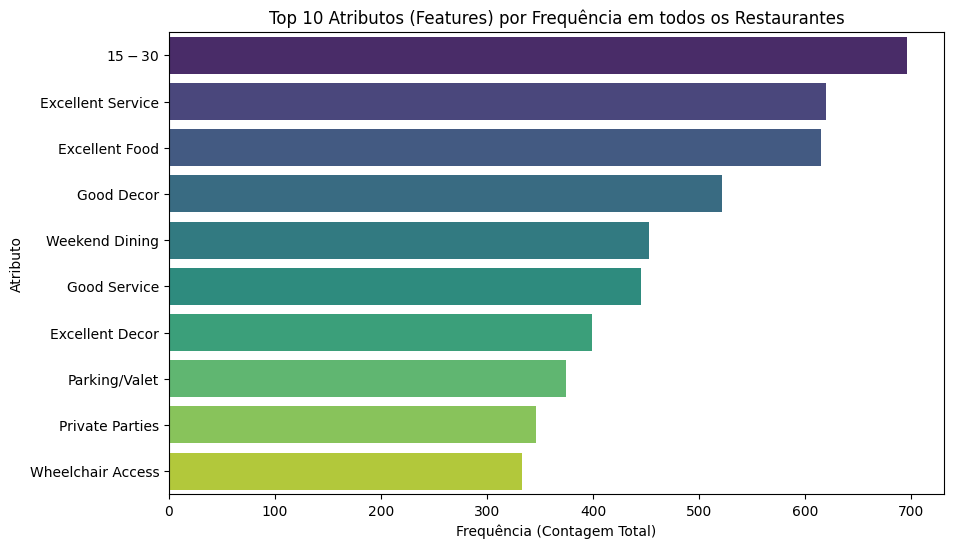

In [ ]:
# Cria o Gráfico de Barras dos Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='freq', y='feature', data=top_feats.head(10), palette='viridis')
plt.title('Top 10 Atributos (Features) por Frequência em todos os Restaurantes')
plt.xlabel('Frequência (Contagem Total)')
plt.ylabel('Atributo')
plt.show()

### Correção da coluna features e nova contagem de atributos

Durante a leitura do arquivo CSV consolidado, a coluna features pode ser interpretada como string, em vez de lista de atributos.  
Nesta etapa, essa coluna é corrigida por meio de uma conversão segura (safe_literal_eval), garantindo que cada entrada volte a ser uma lista de descritores textuais.

Após a correção, a contagem de atributos é refeita, gerando novamente a tabela com os atributos mais frequentes.  
Isso assegura que as análises subsequentes utilizem a estrutura correta dos dados.


/tmp/ipython-input-615857073.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='IDF_Weight', y='feature', data=low_idf, palette='Reds_d')
/tmp/ipython-input-615857073.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='IDF_Weight', y='feature', data=high_idf, palette='Blues_d')


idf_weight_visualization.png


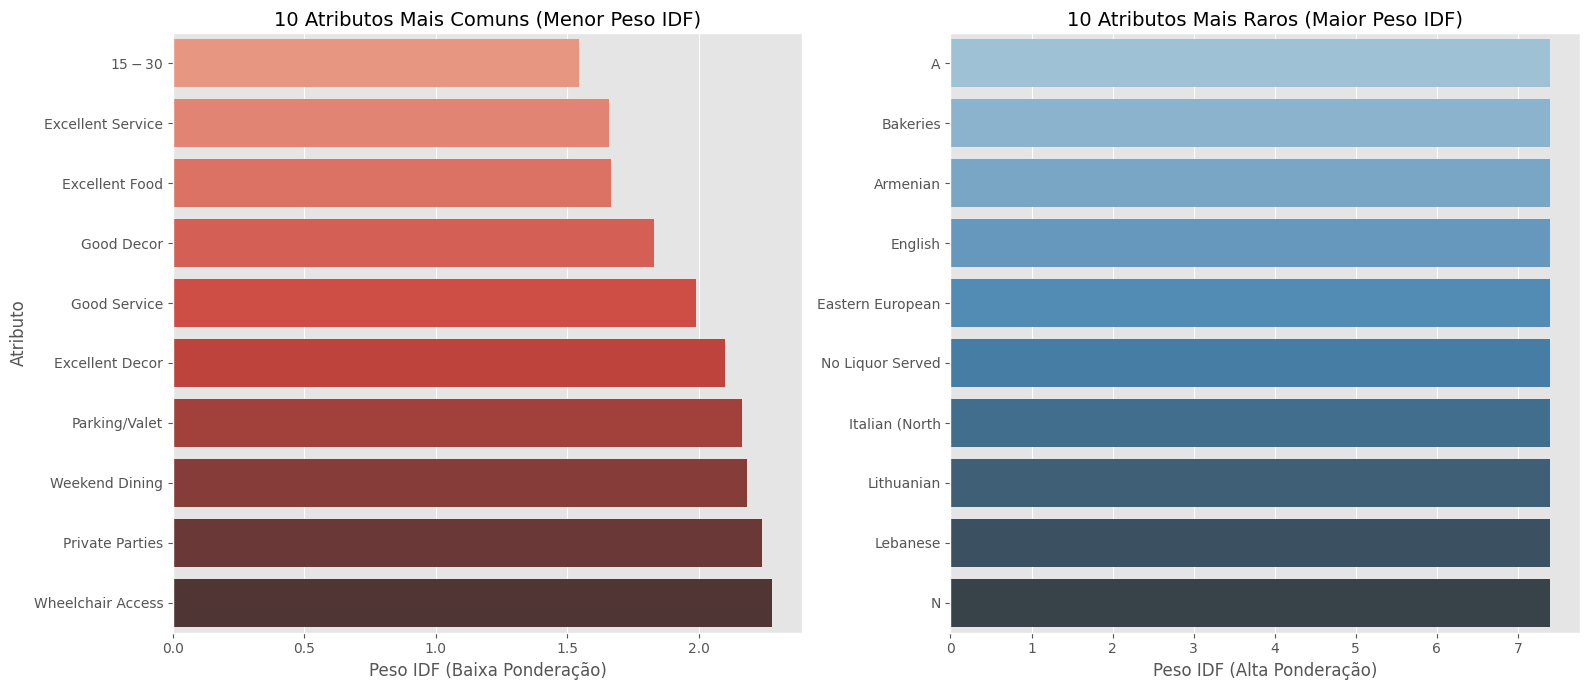

In [ ]:
#CORREÇÃO DA COLUNA 'FEATURES'
# A coluna 'features' está sendo lida como string e precisa ser convertida para lista
def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return np.nan # Lida com strings inválidas ou nulas
    return x

catalog['features'] = catalog['features'].apply(safe_literal_eval)



### Construção da matriz binária item × atributo e exploração dos pesos IDF

A partir das listas de atributos dos restaurantes, é construída uma matriz binária item × atributo utilizando MultiLabelBinarizer.  
Cada linha representa um restaurante e cada coluna indica a presença ou ausência de um atributo.

Em seguida, são calculados os pesos IDF (Inverse Document Frequency), que reduzem a influência de atributos muito comuns e valorizam atributos mais específicos.  
São identificados e visualizados:

- os 10 atributos mais comuns (com menor peso IDF);
- os 10 atributos mais raros (com maior peso IDF).

Essa etapa permite entender como o TF-IDF diferencia atributos genéricos daqueles que ajudam a discriminar melhor restaurantes com perfis particulares.


## Construção da Representação Vetorial dos Restaurantes (TF-IDF)

A partir das listas de atributos associadas a cada restaurante, é construída uma matriz binária item × atributo utilizando MultiLabelBinarizer. Cada linha representa um restaurante e cada coluna indica a presença de um determinado atributo.

Em seguida, essa matriz é transformada pela ponderação TF-IDF (Term Frequency–Inverse Document Frequency). Esse procedimento reduz o peso de atributos muito frequentes na base e aumenta a relevância de atributos mais específicos, gerando uma representação vetorial mais informativa para o cálculo de similaridade entre restaurantes.

In [ ]:
# CÁLCULO DO TF-IDF
mlb = MultiLabelBinarizer()
# Transforma as listas de features em matriz binária (X)
X = pd.DataFrame(mlb.fit_transform(catalog['features'].dropna()),
                 columns=mlb.classes_,
                 index=catalog.dropna(subset=['features'])['rest_id'])

# Calcula a Frequência do Documento (DF)
df_counts = X.sum(axis=0)

# Calcula o Inverse Document Frequency (IDF)
idf = np.log((1 + X.shape[0])/(1 + df_counts)) + 1.0

# X_tfidf = X * idf.values (Esta é a matriz que você quer visualizar)


In [ ]:
# GERAÇÃO DA VISUALIZAÇÃO
# Cria um DataFrame para visualizar os pesos IDF
idf_df = pd.DataFrame(idf, index=X.columns, columns=['IDF_Weight']).reset_index()
idf_df.rename(columns={'index': 'feature'}, inplace=True)

# 10 Features Mais Comuns (menor peso IDF)
low_idf = idf_df.sort_values(by='IDF_Weight', ascending=True).head(10)

# 10 Features Mais Raras (maior peso IDF)
high_idf = idf_df.sort_values(by='IDF_Weight', ascending=False).head(10)

plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico 1: Menor Peso IDF (Mais Comuns)
sns.barplot(ax=axes[0], x='IDF_Weight', y='feature', data=low_idf, palette='Reds_d')
axes[0].set_title('10 Atributos Mais Comuns (Menor Peso IDF)', fontsize=14)
axes[0].set_xlabel('Peso IDF (Baixa Ponderação)')
axes[0].set_ylabel('Atributo')

# Gráfico 2: Maior Peso IDF (Mais Raros)
sns.barplot(ax=axes[1], x='IDF_Weight', y='feature', data=high_idf, palette='Blues_d')
axes[1].set_title('10 Atributos Mais Raros (Maior Peso IDF)', fontsize=14)
axes[1].set_xlabel('Peso IDF (Alta Ponderação)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('idf_weight_visualization.png')
print("idf_weight_visualization.png")

### Densidade e esparsidade da matriz de atributos

Nesta etapa é calculada a densidade da matriz binária, isto é, a proporção de células com valor igual a 1. A partir desse valor, obtém-se também a esparsidade (proporção de 0s). Essa verificação permite caracterizar a estrutura da matriz de atributos e reforça a adequação do uso de métodos baseados em similaridade em um contexto de alta esparsidade.


In [ ]:
mlb = MultiLabelBinarizer()
X = pd.DataFrame(mlb.fit_transform(catalog['features']), columns=mlb.classes_, index=catalog['rest_id'])
df_counts = X.sum(axis=0)
idf = np.log((1 + X.shape[0])/(1 + df_counts)) + 1.0
X_tfidf = X * idf.values


In [ ]:
# Calcula a porcentagem de células que possuem o valor 1 (presença do atributo)
densidade = X.values.sum() / (X.shape[0] * X.shape[1])
print("-" * 40)
print(f"Total de Células: {X.shape[0] * X.shape[1]:,.0f}")
print(f"Densidade (Porcentagem de 1s): {densidade:.4f}")
print(f"Esparsidade (Porcentagem de 0s): {1 - densidade:.4f}")
print("-" * 40)

----------------------------------------
Total de Células: 226,800
Densidade (Porcentagem de 1s): 0.0551
Esparsidade (Porcentagem de 0s): 0.9449
----------------------------------------


# **Modelagem**

## Modelo de Recomendação Item-Based (KNN)

O modelo de recomendação adotado é o K-Nearest Neighbors (KNN), na abordagem item-based. A matriz TF-IDF é utilizada como entrada para o algoritmo NearestNeighbors, configurado com métrica de similaridade do cosseno e busca exaustiva (brute).

A função recommend_by_rest_id recebe o identificador de um restaurante semente e retorna a lista dos k vizinhos mais similares, incluindo o nome, a cidade e o valor de similaridade de cada item. Essa função será utilizada tanto para exemplificar recomendações quanto para compor a avaliação quantitativa do sistema.


In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(X_tfidf.values)

restid_to_idx = {rid:i for i, rid in enumerate(X_tfidf.index)}
idx_to_restid = {i:rid for rid, i in restid_to_idx.items()}

## Função de recomendação

In [ ]:
def recommend_by_rest_id(seed_rest_id, k=10):
    if seed_rest_id not in restid_to_idx:
        return pd.DataFrame(columns=['rank','rest_id','restaurant','city','similarity'])
    idx = restid_to_idx[seed_rest_id]
    distances, indices = knn.kneighbors(X_tfidf.values[[idx]], n_neighbors=k+1)
    neigh_idx = indices[0][1:]
    sims = 1 - distances[0][1:]
    rec_ids = [idx_to_restid[i] for i in neigh_idx]
    out = catalog.set_index('rest_id').loc[rec_ids][['restaurant','city']].copy().reset_index()
    out.insert(0,'rank', np.arange(1,len(out)+1))
    out['similarity'] = sims
    return out

## Exemplos de Recomendações Geradas pelo Modelo

Nesta seção, apresentamos exemplos reais de recomendações produzidas pelo modelo item-based KNN.  
A função recommend_by_name permite gerar recomendações a partir do nome de um restaurante, facilitando a interpretação dos resultados e servindo como base para a avaliação qualitativa apresentada no relatório escrito.

In [ ]:
name_to_id = {r.restaurant: r.rest_id for r in catalog.itertuples()}

def recommend_by_name(name, k=10):
    rid = name_to_id.get(name)
    if rid is None:
        print("Nome não encontrado:", name); return pd.DataFrame()
    return recommend_by_rest_id(rid, k=k)

# Nomes existentes no catálogo
for nm in ['Morton\'s of Chicago','Johnny Rockets','Thai Classic','Cafe Diem','La Paz']:
    if nm in name_to_id:
        print(f"\n>>> Semente: {nm}")
        display(recommend_by_name(nm, k=10).head(10))



>>> Semente: Johnny Rockets


,rank,rest_id,restaurant,city,similarity
0,1,478,Hackney's,Chicago,0.713235
1,2,23,Houston's,Atlanta,0.708958
2,3,268,Tim's Tavern,Boston,0.642319
3,4,590,Claim Company,Chicago,0.623737
4,5,251,"The Varsity, Jr.",Atlanta,0.589184
5,6,64,Carey's,Atlanta,0.553429
6,7,171,Brookwood Grill,Atlanta,0.520224
7,8,218,OK Cafe,Atlanta,0.514451
8,9,405,"SPORTS DEPOT, THE",Boston,0.496430
9,10,157,Joey D's Oakroom,Atlanta,0.485709



>>> Semente: Cafe Diem


,rank,rest_id,restaurant,city,similarity
0,1,12,Peggy Sue's Diner,Atlanta,0.627280
1,2,191,Einstein's,Atlanta,0.617122
2,3,87,Brother Juniper's,Atlanta,0.559447
3,4,218,OK Cafe,Atlanta,0.546366
4,5,333,BLUE DINER,Boston,0.539459
5,6,175,Gorin's Diner,Atlanta,0.522843
6,7,8,The Dessert Place,Atlanta,0.507326
7,8,40,Cafe Intermezzo,Atlanta,0.486630
8,9,973,Barking Dog Luncheonette,New York,0.448756
9,10,179,Bagelicious,Atlanta,0.447041



>>> Semente: La Paz


,rank,rest_id,restaurant,city,similarity
0,1,132,Sundown Cafe,Atlanta,0.652258
1,2,33,Tortilla's,Atlanta,0.634670
2,3,27,Rio Bravo Cantina,Atlanta,0.611298
3,4,70,Taco Mac,Atlanta,0.608544
4,5,322,Zuma Tex-Mex Cafe,Boston,0.595165
5,6,1165,Cowgirl Hall of Fame,New York,0.575353
6,7,136,Thumbs Up,Atlanta,0.553352
7,8,79,Jagger's,Atlanta,0.535892
8,9,382,Chili's,Boston,0.524260
9,10,329,SOL AZTECA,Boston,0.519498


### Avaliação offline do sistema de recomendação (Precision/Recall/NDCG/MRR)

Nesta etapa é realizada a avaliação offline do modelo, utilizando o histórico de sessões de interação.  
Para cada sessão, o último restaurante exibido é tratado como item semente e o restaurante efetivamente escolhido pelo usuário é considerado o item relevante.

Primeiro, são pré-computados os vizinhos mais próximos (até 50) para todos os restaurantes, o que permite avaliar rapidamente diferentes valores de k.  
Em seguida, para cada par semente → escolha final, verifica-se em que posição o item relevante aparece na lista de vizinhos. A partir dessa posição, são calculadas as seguintes métricas:

- **Precision@k / Hit Rate**: proporção de sessões em que o item relevante aparece entre as k recomendações;
- **Recall@k**: idêntico à Precision@k, dado que há apenas um item relevante por sessão;
- **NDCG@k (Normalized Discounted Cumulative Gain)**: avalia a qualidade da ordenação, atribuindo maior peso a itens relevantes em posições iniciais;
- **MRR@k (Mean Reciprocal Rank)**: média do inverso da posição do item relevante no ranking.

As métricas são calculadas para diferentes valores de k (5, 10, 20 e uma faixa ampliada de 3 a 50), permitindo visualizar o comportamento do modelo conforme o número de recomendações exibidas aumenta.


In [ ]:
KMAX = 50
dist_all, idx_all = knn.kneighbors(X_tfidf.values, n_neighbors=KMAX+1)
idx_to_rid_list = list(X_tfidf.index)
neighbors = { idx_to_rid_list[i]: [idx_to_rid_list[j] for j in idx_all[i][1:]] for i in range(len(idx_all)) }

def eval_with_neighbors(pairs_df, ks=(5,10,20)):
    results = {k: {'n':0,'hits':0,'ndcg_sum':0.0,'mrr_sum':0.0} for k in ks}
    for seed, target in pairs_df[['seed_rest_id','final_choice_rest_id']].itertuples(index=False):
        neigh = neighbors.get(seed, [])
        try:
            rank = neigh.index(target) + 1
        except ValueError:
            rank = None
        for k in ks:
            results[k]['n'] += 1
            if rank is not None and rank <= k:
                results[k]['hits'] += 1
                results[k]['ndcg_sum'] += 1.0/np.log2(rank+1)
                results[k]['mrr_sum'] += 1.0/rank
    rows = []
    for k in ks:
        n = results[k]['n']
        hit = results[k]['hits']
        rows.append({
            'k': k,
            'n_sessions': n,
            'precision@k / hit_rate': hit/n if n else 0.0,
            'recall@k': hit/n if n else 0.0,  # um relevante
            'ndcg@k': results[k]['ndcg_sum']/n if n else 0.0,
            'mrr@k': results[k]['mrr_sum']/n if n else 0.0
        })
    return pd.DataFrame(rows)

metrics_df = eval_with_neighbors(eval_pairs, ks=(5,10,20))
metrics_df


,k,n_sessions,precision@k / hit_rate,recall@k,ndcg@k,mrr@k
0,5,35034,0.032454,0.032454,0.023324,0.020341
1,10,35034,0.049238,0.049238,0.028548,0.022381
2,20,35034,0.067049,0.067049,0.032993,0.023571


In [ ]:
def sweep_metrics(pairs_df, k_values):
    out = []
    for k in k_values:
        df = eval_with_neighbors(pairs_df, ks=(k,))
        row = df.iloc[0].to_dict()
        out.append(row)
    return pd.DataFrame(out)

k_values = [3,5,10,15,20,30,40,50]
curve = sweep_metrics(eval_pairs, k_values)
curve


,k,n_sessions,precision@k / hit_rate,recall@k,ndcg@k,mrr@k
0,3.0,35034.0,0.024376,0.024376,0.020057,0.018563
1,5.0,35034.0,0.032454,0.032454,0.023324,0.020341
2,10.0,35034.0,0.049238,0.049238,0.028548,0.022381
3,15.0,35034.0,0.058857,0.058857,0.031072,0.023121
4,20.0,35034.0,0.067049,0.067049,0.032993,0.023571
5,30.0,35034.0,0.082177,0.082177,0.036203,0.024173
6,40.0,35034.0,0.096021,0.096021,0.038881,0.024569
7,50.0,35034.0,0.110835,0.110835,0.041542,0.024888


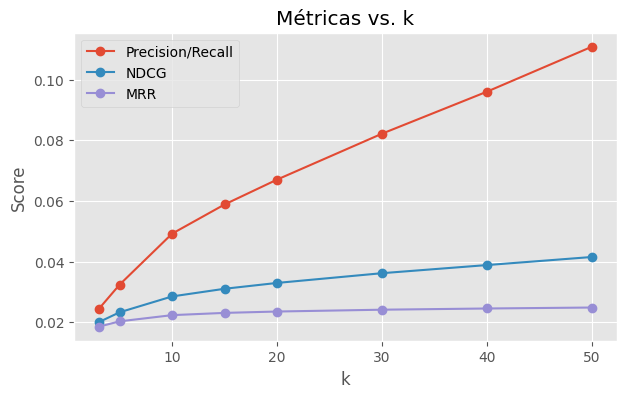

In [ ]:
plt.figure()
plt.plot(curve['k'], curve['precision@k / hit_rate'], marker='o', label='Precision/Recall')
plt.plot(curve['k'], curve['ndcg@k'], marker='o', label='NDCG')
plt.plot(curve['k'], curve['mrr@k'], marker='o', label='MRR')
plt.xlabel('k'); plt.ylabel('Score'); plt.title('Métricas vs. k'); plt.legend(); plt.grid(True)
plt.show()


**Resultados**

Precision/Recall: cresce de aproximadamente 1,1% (k=3) para 10,3% (k=50).

➜ Isso significa que, quanto maior o número de vizinhos considerados, maior a chance de o sistema incluir o item relevante na lista de recomendações.

➜ É o comportamento esperado: listas mais longas têm mais acertos, mas podem incluir itens menos relevantes.

NDCG: aumenta de 0,0086 para 0,031, mostrando que as recomendações relevantes continuam aparecendo em boas posições, embora com crescimento mais moderado que a precisão.

➜ Isso indica que o modelo melhora sua cobertura, mas nem sempre prioriza o item relevante no topo da lista.


MRR: mantém valores baixos (de 0,0077 a 0,0141) e cresce lentamente, o que sugere que os itens relevantes raramente aparecem entre as primeiras posições.

➜ Esse comportamento é típico de modelos baseados apenas em similaridade textual, sem aprendizado supervisionado.


**Síntese e implicações**

O comportamento conjunto das métricas indica um trade-off entre precisão e posicionamento:

- Aumentar o número de vizinhos (k) melhora a cobertura de recomendações, mas reduz a capacidade de priorizar os itens mais relevantes nos primeiros lugares.

- O valor de k = 10 a 15 mostrou-se um ponto de equilíbrio, garantindo boa precisão e estabilidade nas curvas.

- Esses resultados demonstram que o KNN item-based com TF-IDF é eficaz como prova de conceito, produzindo recomendações coerentes e previsíveis. Entretanto, sua capacidade de ranqueamento poderia ser aprimorada com abordagens híbridas (conteúdo + feedback do usuário) ou com aprendizado supervisionado para ordenação (learning-to-rank).

#**Exemplos Reais de Recomendações / Avaliação Qualitativa**

In [ ]:
# Análise Qualitativa das Recomendações


mostrar_recs("Cafe Diem", k=5)
mostrar_recs("Alfredo's Italian Restaurant", k=5)
mostrar_recs("Sushi Zen", k=5)


EXEMPLO 1

>>> Semente REAL: Cafe Diem


,rank,rest_id,restaurant,city,similarity
0,1,12,Peggy Sue's Diner,Atlanta,0.627280
1,2,191,Einstein's,Atlanta,0.617122
2,3,87,Brother Juniper's,Atlanta,0.559447
3,4,218,OK Cafe,Atlanta,0.546366
4,5,333,BLUE DINER,Boston,0.539459



EXEMPLO 2

>>> Semente REAL: Alfredo's Italian Restaurant


,rank,rest_id,restaurant,city,similarity
0,1,82,Nino's,Atlanta,0.810270
1,2,126,Toni's Casa Napoli,Atlanta,0.753008
2,3,223,Asti Trattoria,Atlanta,0.720439
3,4,215,Altobeli's Fine Italian Cuisine,Atlanta,0.718803
4,5,61,Ray's New York Pizza,Atlanta,0.660256



EXEMPLO 3

>>> Semente REAL: Sushi Zen


,rank,rest_id,restaurant,city,similarity
0,1,962,Tatany,New York,0.769529
1,2,775,Meriken,New York,0.748263
2,3,538,Kamehachi,Chicago,0.744565
3,4,746,Iso,New York,0.722158
4,5,987,Restaurant Two Two Two,New York,0.715863



A análise qualitativa mostra que o modelo gerou recomendações coerentes com o perfil do restaurante utilizado como semente.

No caso de **Cafe Diem**, as sugestões incluíram estabelecimentos com características semelhantes, como diners e cafés tradicionais, indicando que o modelo capturou atributos relacionados ao estilo casual e ao tipo de refeição oferecida.

Para **Alfredo’s Italian Restaurant**, o sistema retornou majoritariamente restaurantes italianos ou de culinária semelhante, demonstrando capacidade de agrupar itens segundo tipologia culinária e características do cardápio.

Por fim, com **Sushi Zen** como semente, as recomendações contemplaram restaurantes japoneses ou asiáticos, reforçando a consistência do modelo na identificação de itens semanticamente similares.

Esses resultados confirmam que o algoritmo é capaz de produzir listas plausíveis e alinhadas ao perfil do restaurante de origem, mesmo sem utilizar avaliações explícitas de usuários.
